In [1]:
import numpy as np
import matplotlib.pyplot as plt

import gpcg

import scipy.sparse as sps
from scipy.ndimage import gaussian_filter
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import cg as scipy_cg
from scipy.sparse.linalg import aslinearoperator


from csias import CSIASSolver1D

# 1D Example

In [2]:
# Problem parameters
N = 100
noise_sigma = 0.2
reg_lambda = 1e2

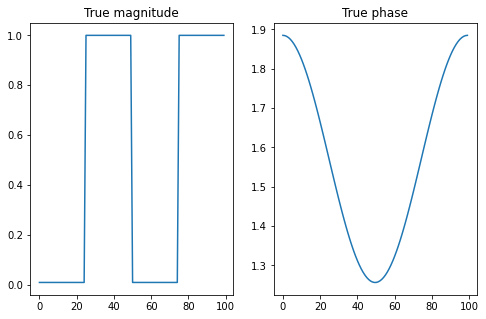

In [3]:
# Magnitude
mag = np.zeros(N) + 1e-2
mag[25:50] = 1.0
mag[75:] = 1.0

#mag += 2

# Phase
dom = np.linspace(0,2*np.pi,N)
#phase = 0.75*np.pi*np.cos(dom)
phase = 0.1*np.pi*np.cos(dom) + np.pi/2

fig, axs = plt.subplots(1, 2, figsize=(8,5))

axs[0].plot(mag)
axs[0].set_title("True magnitude")

axs[1].plot(phase)
axs[1].set_title("True phase")

plt.show()

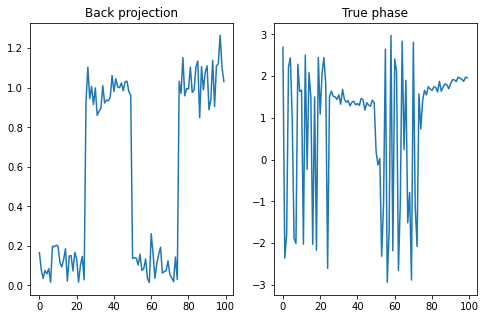

In [4]:
# Put together
x_true = mag*np.exp(1j*phase) 

# Create noisy observation
y = np.fft.fft(x_true, norm="ortho")
y += ( (noise_sigma/2)*np.random.randn(N) ) + ( (noise_sigma/2)*1j*np.random.randn(N) )
back_proj = np.fft.ifft(y, norm="ortho")

fig, axs = plt.subplots(1, 2, figsize=(8,5))

axs[0].plot(np.abs(back_proj))
axs[0].set_title("Back projection")

axs[1].plot(np.angle(back_proj))
axs[1].set_title("True phase")

plt.show()

In [5]:
# Solve problem with Tikhonov
R = np.eye(N)
np.fill_diagonal(R[1:], -1)
R = R[1:, :]
R = aslinearoperator(R)

csias_solver = CSIASSolver1D(y, R, noise_sigma=noise_sigma)

data = csias_solver.solve_with_tikhonov(reg_lambda=reg_lambda)
recon_mag, recon_phase = data["magnitude"], data["phase"]

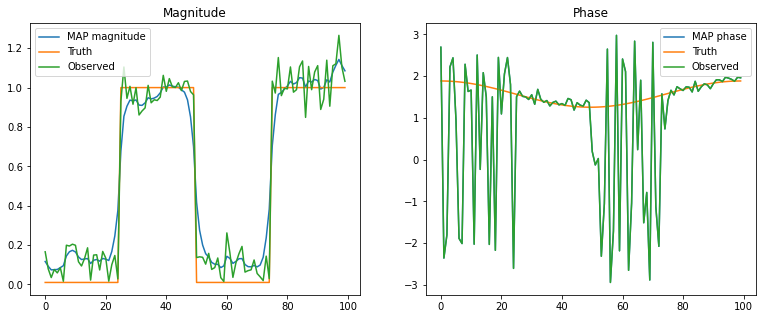

In [6]:

fig, axs = plt.subplots(1, 2, figsize=(13,5))

axs[0].plot(recon_mag, label="MAP magnitude")
axs[0].plot(mag, label="Truth")
axs[0].plot(np.abs(back_proj), label="Observed")
axs[0].set_title("Magnitude")
axs[0].legend()

axs[1].plot(recon_phase, label="MAP phase")
axs[1].plot(phase, label="Truth")
axs[1].plot(np.angle(back_proj), label="Observed")
axs[1].legend()
axs[1].set_title("Phase")

plt.show()

# Nonconvex example

In [7]:
# Make regularization operator
R = np.eye(N)
np.fill_diagonal(R[1:], -1)
R = R[1:, :]

R = aslinearoperator(R)

# Hyper-prior parameters
hyperparameters = {
    "r": -1,
    "s": 1,
    "vartheta": 1e-3,
}

csias_solver = CSIASSolver1D(y, R, noise_sigma=noise_sigma)
data = csias_solver.solve_with_ias(hyperparameters=hyperparameters, n_iterations=100)

recon_mag = data["magnitude"]
recon_phase = data["phase"]

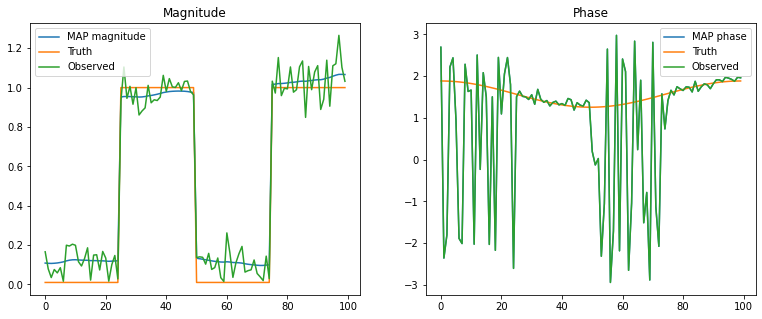

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(13,5))

axs[0].plot(recon_mag, label="MAP magnitude")
axs[0].plot(mag, label="Truth")
axs[0].plot(np.abs(back_proj), label="Observed")
axs[0].set_title("Magnitude")
axs[0].legend()

axs[1].plot(recon_phase, label="MAP phase")
axs[1].plot(phase, label="Truth")
axs[1].plot(np.angle(back_proj), label="Observed")
axs[1].legend()
axs[1].set_title("Phase")

plt.show()

# Convex example (approximation to TV)

In [9]:
# Make regularization operator
R = np.eye(N)
np.fill_diagonal(R[1:], -1)
R = R[1:, :]

R = aslinearoperator(R)

# Hyper-prior parameters
hyperparameters = {
    "r": 1,
    "s": 1.5 + 1e-2,
    "vartheta": 1e-3,
}

csias_solver = CSIASSolver1D(y, R, noise_sigma=noise_sigma)
data = csias_solver.solve_with_ias(hyperparameters=hyperparameters, n_iterations=100)

recon_mag = data["magnitude"]
recon_phase = data["phase"]

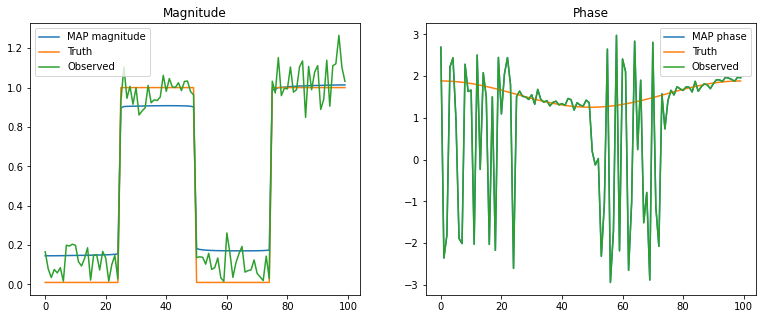

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(13,5))

axs[0].plot(recon_mag, label="MAP magnitude")
axs[0].plot(mag, label="Truth")
axs[0].plot(np.abs(back_proj), label="Observed")
axs[0].set_title("Magnitude")
axs[0].legend()

axs[1].plot(recon_phase, label="MAP phase")
axs[1].plot(phase, label="Truth")
axs[1].plot(np.angle(back_proj), label="Observed")
axs[1].legend()
axs[1].set_title("Phase")

plt.show()

# 2D example